# Part 3: Neural Networks

In this example, we introduce **neural networks** for classifying images of cats and dogs. This example builds on content from the [previous notebook on logistic regression](2_logistic_regression.ipynb).

<img src="images/dog_classifier_pipeline.png">

# Setup

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [3]:
# Settings
NUM_WORKERS = 2
DATA_DIR_EXTENSION = 'D:/datasets/Cat_Dog_data/'
DATA_DIR = DATA_DIR_EXTENSION + 'Cat_Dog_data'  # set data path to ``Cat_Dog_data``
NUM_CLASSES = 2

# Hyperparameters
BATCH_SIZE = 4
RESIZE = 32 # Modify image dimensions to RESIZE x RESIZE
NUM_EPOCH = 5
LEARNING_RATE = 0.01
MOMENTUM = 0.9

# Prepare Data

In [4]:
# # Download Cat_Dog dataset
# !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

# # Path to training data: ``Cat_Dog_data/train``
# # Path to testing data: ``Cat_Dog_data/test``
# !unzip -qq Cat_Dog_data.zip

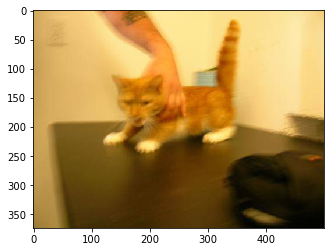

(374, 500, 3)


In [5]:
# Show an example image
example_img = Image.open(DATA_DIR + '/train/cat/cat.0.jpg')
plt.imshow(example_img)
plt.show()

# PIL image to NumPy array
numpy_img = np.array(example_img)
print(numpy_img.shape) # (Height, Width, Channels)

In [6]:
# Transform to preprocess images
# 1. Resize image to the same height and width
# 2. Convert image (H x W x C) in range [0, 255] to torch tensor (C x H x W) in 
# the range [0.0, 1.0]
transform = transforms.Compose([transforms.Resize((RESIZE, RESIZE)),
                                 transforms.ToTensor()])

# Create training dataloader
train_set = torchvision.datasets.ImageFolder(root=DATA_DIR + '/train', 
                                             transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=True, 
                                           num_workers=NUM_WORKERS)

# Create testing dataloader
test_set = torchvision.datasets.ImageFolder(root=DATA_DIR + '/test', 
                                        transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, 
                                          num_workers=NUM_WORKERS)

In [7]:
print('Number of training samples:', len(train_set))
print('Number of testing samples:', len(test_set))

Number of training samples: 22500
Number of testing samples: 2500


Shape: torch.Size([3, 32, 32])


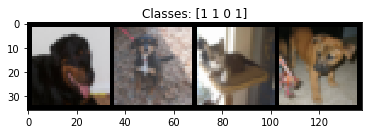

In [8]:
# Load one data batch
inputs, classes = next(iter(train_loader))

# Print image shape
print('Shape:', inputs[0].shape)

# Visualize the data batch
out = torchvision.utils.make_grid(inputs)
plt.imshow(out.permute(1, 2, 0))
plt.title('Classes: ' + str(classes.numpy()))
plt.show()

# Model

Here we are going to use a **neural network** to classify our images.

<img src="images/neural_network.png">

In [9]:
# Two layer linear neural network
class LinearNet(nn.Module):

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc1 = nn.Linear(RESIZE*RESIZE*3, (RESIZE*RESIZE*3)//2)
        self.fc2 = nn.Linear((RESIZE*RESIZE*3)//2, 1)

    def forward(self, x):
        x = x.view(BATCH_SIZE, -1)  # flatten image into a vector
        x = self.fc1(x)             
        x = self.fc2(x)
        x = nn.Sigmoid()(x)         # sigmoid layer
        x = x.squeeze()
        return x

In [11]:
net = LinearNet()

# Send model to GPU
net = net.cuda() 

# Loss Function

In [12]:
# Define loss function
criterion = nn.BCELoss()

# Optimizer

In [13]:
# Define optimizer
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# Training the Model

In [14]:
for epoch in range(NUM_EPOCH):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0): # learn from 1 batch
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        labels = labels.type(torch.FloatTensor) # cast labels to float

        # Send data to GPU
        inputs = inputs.cuda()
        labels = labels.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward propagation
        outputs = net(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward propagation
        loss.backward()

        # Optimize
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('Epoch: %d | Batch: %5d | Loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Epoch: 1 | Batch:  2000 | Loss: 0.885
Epoch: 1 | Batch:  4000 | Loss: 0.927
Epoch: 2 | Batch:  2000 | Loss: 0.987
Epoch: 2 | Batch:  4000 | Loss: 0.984
Epoch: 3 | Batch:  2000 | Loss: 7.155
Epoch: 3 | Batch:  4000 | Loss: 13.793
Epoch: 4 | Batch:  2000 | Loss: 13.867
Epoch: 4 | Batch:  4000 | Loss: 13.675
Epoch: 5 | Batch:  2000 | Loss: 13.858
Epoch: 5 | Batch:  4000 | Loss: 13.791
Finished Training


# Evaluation

In [15]:
correct = 0
total = 0

# Switch network to evaluation mode
net.eval()

with torch.no_grad(): # we don't need gradients for evaluation
    for data in test_loader:
        # Get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # Send data to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # Get prediction
        outputs = net(images)
        predicted = (outputs > 0.5).float()
        
        # Accumulate statistics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 50 %


In [16]:
correct = 0
total = 0

# Switch network to evaluation mode
net.eval()

with torch.no_grad(): # we don't need gradients for evaluation
    for data in train_loader:
        # Get the inputs; data is a list of [inputs, labels]
        images, labels = data

        # Send data to GPU
        images = images.cuda()
        labels = labels.cuda()
        
        # Get prediction
        outputs = net(images)
        predicted = (outputs > 0.5).float()
        
        # Accumulate statistics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on train images: 50 %


In [17]:
all_labels = []
all_predictions = []
classes = ('cat', 'dog')
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        predicted = (outputs > 0.5).float()
        c = (predicted == labels).squeeze()
        for i in range(BATCH_SIZE):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            all_labels.append(int(labels[i].to("cpu").numpy()))
            all_predictions.append(int(predicted[i].to("cpu").numpy()))
            
for i in range(NUM_CLASSES):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   cat : 100 %
Accuracy of   dog :  0 %


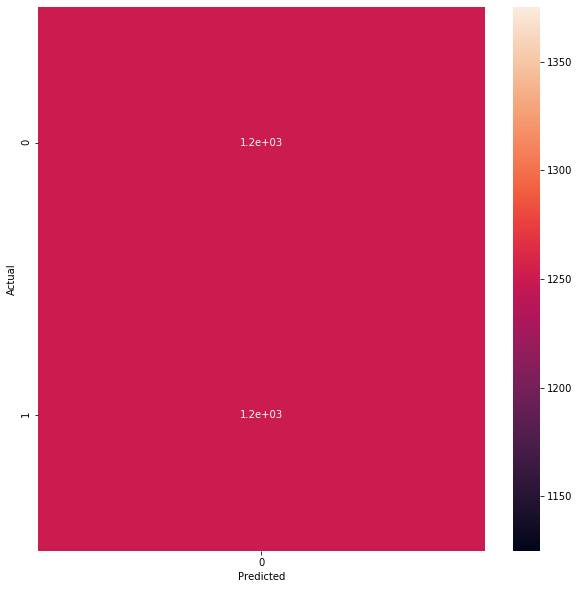

In [18]:
# class 0 -> cat
# class 1 -> dog
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual': all_labels, 'y_Predicted': all_predictions}
df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

fig, ax = plt.subplots(figsize=(10,10))  
sn.heatmap(confusion_matrix, annot=True, ax=ax)